In [81]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from math import ceil
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import string
from math import log10
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [83]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [111]:
tweet_stops = stopwords.words('english')
tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

def clean_tweet(tweet):
#     takes input string and converts or removes characters depending on settings.
#     returns a string
#     convert case:
    tweet = tweet.lower()
#     remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
#     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
#     remove punctuation, but not hashtags:
    tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
#     remove non-hashtag '#'.
    tweet = re.sub('#\B','',tweet)
#     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
#     drop numbers and words of < 4 characters.
    tweet = re.sub(r'\b\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_as_tokens = tweet_tokenizer.tokenize(cleaned_tweet)
    tweet_no_stops = [word for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

In [136]:
search_term = "irma"

In [137]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [138]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [139]:
for i in range(1,11):
    for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
        tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]

        tweets_tokens = tweet_text.apply(tokens_no_stopwords)
#         this line uses the for loop to iterate the context window size for any given word
        vector_model = Word2Vec(tweets_tokens, min_count=1, window=i, workers=1, size=100, seed=1, sg=1)

#         this line uses the for loop to iterate the minimum word count for inclusion in the vectors:
#         vector_model = Word2Vec(tweets_tokens, min_count=i*10, window=6, workers=1, size=100, seed=1, sg=1)
        
        word_matrix = vector_model.wv[vector_model.wv.vocab]
        vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

        vectors_series.iloc[i] = vector_model

In [118]:
# comparison_type = "Min. Word Freq."
# comparison_short = "MinWordFreq"
comparison_type = "Window Size"
comparison_short = "WindowSize"

In [90]:
# pickle.dump(vectors_series,open(r'./pkl_sets/vectors_by_min_word_count.pkl',"wb"))
# pickle.dump(vectors_series,open(r'./pkl_sets/vectors_by_window_size.pkl',"wb"))

In [91]:
# vectors_series = pickle.load(open(r'./pkl_sets/vectors_by_min_word_count.pkl',"rb"))
# vectors_series = pickle.load(open(r'./pkl_sets/vectors_by_window_size.pkl',"rb"))

This is the starting point for changing the scoring function.

In [119]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [120]:
tweet_encoded.columns

Index(['index', 'irma_rel', 'tweet', 'timestamp', 'tweet_id', 'tweet_text',
       'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
       'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags'],
      dtype='object')

In [122]:
# tweet_encoded.loc[:,['timestamp', 'tweet_id','tweet','irma_rel',
#        'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
#        'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags']].to_csv('irma_coded_tweets.csv')

In [95]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [96]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [123]:
func_type = "Dot Product of Tweet Vector and Search Term"
func_short = "DotProduct"
def ScoreTweetFromVectors(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector as 100 dimension vector of zeroes.
    score_matrix = np.zeros(100,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [124]:
tweet_encoded.iloc[0:5].tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[1],))

0    17.988527
1    11.721791
2     8.040028
3     3.916001
4     3.852693
Name: tweet_text, dtype: float64

In [125]:
for i in range(1,11):
    tweet_encoded[f'score_window_{i}'] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))

In [127]:
for i in range(1,11):
    tweet_encoded[f'MM_score_window_{i}'] = (tweet_encoded[f'score_window_{i}'] - tweet_encoded[f'score_window_{i}'].min())* 100 / (tweet_encoded[f'score_window_{i}'].max() - tweet_encoded[f'score_window_{i}'].min())

In [128]:
tweet_encoded.head()

,index,irma_rel,tweet,timestamp,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,...,MM_score_window_1,MM_score_window_2,MM_score_window_3,MM_score_window_4,MM_score_window_5,MM_score_window_6,MM_score_window_7,MM_score_window_8,MM_score_window_9,MM_score_window_10
0,0,1,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",2017-09-10 00:00:01,906668545542680576,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",1227982520,"[28.87527778,-81.2525]","[[[-81.285896, 28.84511], [-81.285896, 28.9640...",-81.2525,...,42.111036,51.525119,48.379509,41.114225,40.332464,40.846455,46.741996,41.676487,37.977787,31.579722
1,1,0,There is always beauty regardless the circumst...,2017-09-10 00:00:03,906668555185291265,There is always beauty regardless the circumst...,42239064,"[29.5381,-81.2234]","[[[-81.279617, 29.424649], [-81.279617, 29.627...",-81.2234,...,27.440643,28.588839,25.156517,29.253743,28.878667,27.717231,31.697177,24.268160,21.078570,24.577102
2,2,0,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,2017-09-10 00:00:03,906668556493889536,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,87188071,"[28.4363045,-81.4797168]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-81.4797,...,18.821658,17.513564,17.628469,22.128823,22.449782,6.760890,7.041567,8.165064,8.327273,7.830104
3,3,0,@avictoria_x nah i m chillin my eyes never get...,2017-09-10 00:00:06,906668570079309830,@avictoria_x nah i m chillin my eyes never get...,746764728,NaN,"[[[-81.25235, 28.549308], [-81.25235, 28.58224...",-81.2380,...,9.167334,2.100696,2.495049,3.864169,4.747176,5.529907,6.591858,7.577408,6.859922,8.813948
4,4,0,@jvnvy @sza That s how I feel bout seein travis,2017-09-10 00:00:08,906668576056246278,@jvnvy @sza That s how I feel bout seein travis,1679199278,NaN,"[[[-82.31457, 27.823335], [-82.31457, 27.85374...",-82.2877,...,9.019132,10.977382,11.140100,13.036264,7.558101,6.120772,7.373684,6.732830,8.436938,7.536271


In [129]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

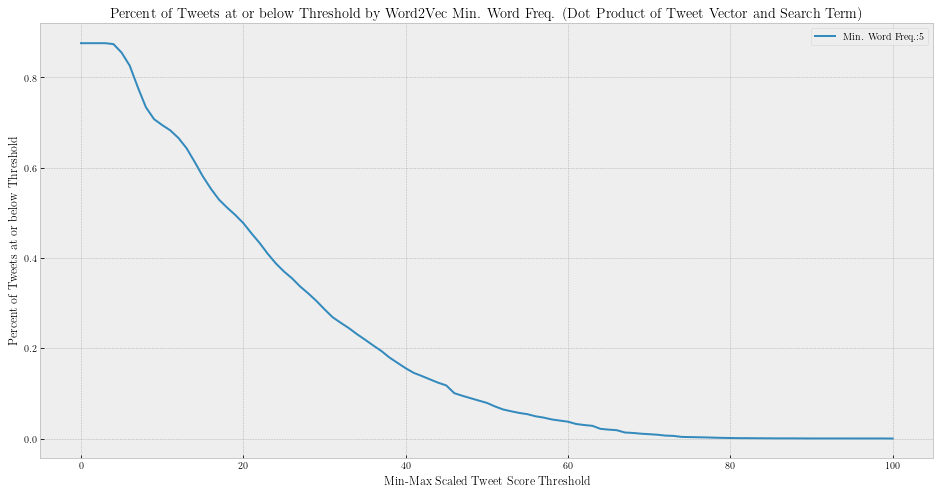

In [130]:
fig_0 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(5,6):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or below Threshold")
plt.title(f"Percent of Tweets at or below Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [104]:
# pd.Series([len(tweet_encoded[tweet_encoded['MM_score_window_'+str(j)] > i])*100/len(tweet_encoded) for i in range(101)]).to_csv('./min_max_window_5_dot.csv')

In [131]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [132]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


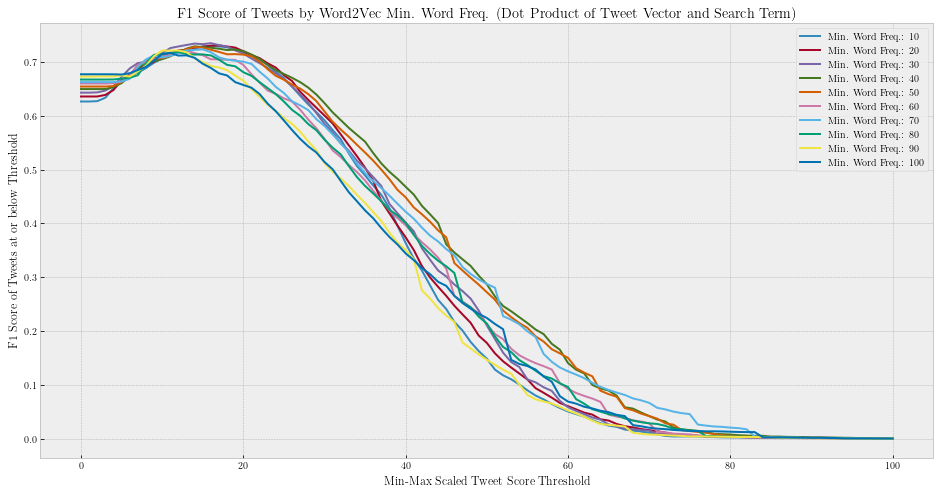

In [140]:
fig_1 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i*10}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets at or below Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

In [108]:
score_table = pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],names=['Window_size','F1_score'],axis=1)

In [134]:
f1_window_score_df.iloc[:,5].idxmax()

14

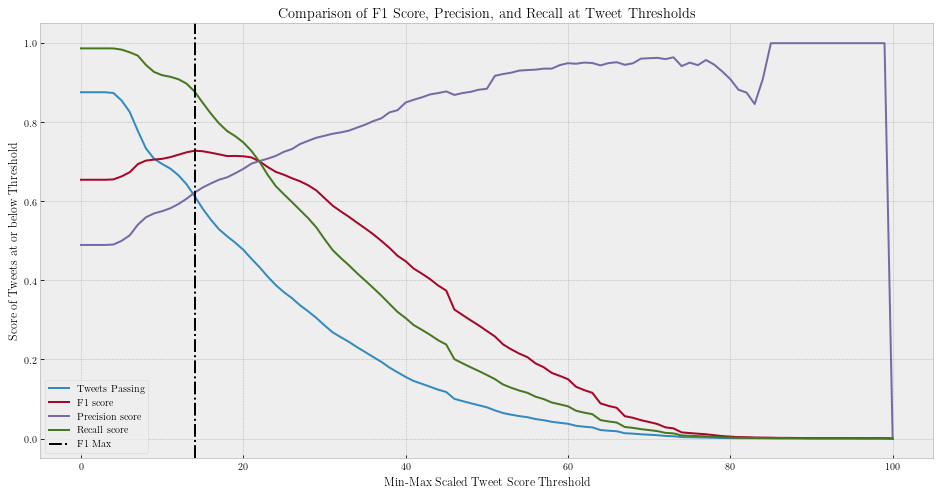

In [135]:
fig_2 = plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.title("Comparison of F1 Score, Precision, and Recall at Tweet Thresholds")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Score of Tweets at or below Threshold")
plt.plot(range(101),[len(tweet_encoded[tweet_encoded['MM_score_window_5'] > i])/len(tweet_encoded) for i in range(101)],label='Tweets Passing')
plt.plot(range(101),f1_window_score_df.iloc[:,5],label='F1 score')
plt.plot(range(101),pre_score_df.iloc[:,5],label='Precision score')
plt.plot(range(101),rec_score_df.iloc[:,5],label='Recall score')
plt.axvline(f1_window_score_df.iloc[:,5].idxmax(),label='F1 Max',color='k',linestyle='-.')

plt.legend();
# fig_2.savefig(f'./figures/{comparison_short}{func_type}compareF1PrecisionRecall.pdf',bbox_inches='tight')